Development of Live Ocean interpolation functions

In [1]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime

from scipy import interpolate

import glob
import os
import re

from salishsea_tools import viz_tools
import grid

import mpl_toolkits.basemap

%matplotlib inline

# Function definitions

Some helper funcions for the interpolation.

In [2]:
# I would prefer to do this with xarray but I'm having issues with units in the boundary files. 
def load_SalishSea_boundary_grid(
    fname='/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/SalishSea2_Masson_corrected.nc'
):
    """Load the Salish Sea NEMO model boundary depth, latitudes and longitudes:
    
    :arg fname: name of boundary file
    :type fname: str
    
    :returns: numpy arrays depth, lon, lat and a tuple shape
    """
    
    f = nc.Dataset(fname)
    depth = f.variables['deptht'][:]
    lon = f.variables['nav_lon'][:]
    lat = f.variables['nav_lat'][:]
    # determine lateral shape of boundary because arrays are flattened
    width = f.variables['nbrdta'][:].flatten()[-1] + 1
    length = int(f.variables['nbrdta'][:].shape[-1]/width)  
    shape = (width, length)
    
    return depth, lon, lat, shape

In [3]:
def load_LiveOcean(files, resample_interval = '1H'):
    """Load a time series of Live Ocean results represented by a list of files. 
    Time series is resampled by averaging over resample_interval.  Default is 1 hour.
    
    :arg files: Live Ocean filenames
    :type files: list of strings
    
    :arg resample_interval: interval for resampling based on pandas values.
                            e.g. 1H is one hour, 7D is seven days, etc
    :type resample_interval: str
    
    :returns: xarray dataset of live ocean results
    """
    # Loop through files and load
    d = xr.open_dataset(files[0])
    for f in files[1:]:
        with xr.open_dataset(f) as d1:
            d =xr.concat([d, d1], dim='ocean_time', data_vars='minimal')
    # Determine z-rho (depth)
    G, S, T = grid.get_basic_info(files[0])  # note: grid.py is a module from Parker. 
    z_rho = np.zeros(d.salt.shape)
    for t in np.arange(z_rho.shape[0]):
        zeta = d.zeta.values[t, : , :]
        z_rho[t, :, :, :] = grid.get_z(G['h'], zeta, S)
    # Add z_rho to dataset
    zrho_DA = xr.DataArray(z_rho, dims = ['ocean_time', 's_rho', 'eta_rho', 'xi_rho'],
                           coords = {'ocean_time': d.ocean_time.values[:],
                                     's_rho': d.s_rho.values[:],
                                     'eta_rho': d.eta_rho.values[:],
                                     'xi_rho': d.xi_rho.values[:]},
                           attrs = {'units': 'metres',
                                    'positive': 'up',
                                    'long_name': 'Depth at s-levels',
                                    'field': 'z_rho ,scalar'})
    d = d.assign(z_rho = zrho_DA)
    # Resample
    d = d.resample(resample_interval, 'ocean_time')
    
    return d

In [4]:
def interpolate_to_NEMO_depths(dataset, NEMO_depths, var_names):
    """Interpolate variables in var_names from a Live Ocean dataset to NEMO depths.
    LiveOcean land points (including points lower than bathymetry) are set to np.nan and then masked. 
    
    :arg dataset: Live Ocean dataset
    :type dataset: xarray Dataset
    
    :arg NEMO_depths: NEMO model depths
    :type NEMO_depths: 1D numpy array
    
    :arg var_names: list of Live Ocean variable names to be interpolated, e.g ['salt', 'temp']
    :type var_names: list of str
    
    :returns: dictionary continaing interpolated numpy arrays for each variable
    """
    interps = {}
    for var_name in var_names:
        var_interp = np.zeros(dataset[var_name].shape)
        for t in np.arange(var_interp.shape[0]):
            for j in np.arange(var_interp.shape[2]):
                for i in np.arange(var_interp.shape[3]):
                    LO_depths = dataset.z_rho.values[t, :, j, i] 
                    var = dataset[var_name].values[t, :, j, i]
                    var_interp[t, :, j, i] = np.interp(-NEMO_depths, LO_depths, var, left=np.nan)
                    # NEMO depths are positive, LiveOcean are negative
        interps[var_name] = np.ma.masked_invalid(var_interp)
    
    return interps

In [5]:
def fill_NaNs_with_nearest_neighbour(data, lons, lats):
    """At each depth level and time, fill in NaN values with nearest lateral neighbour. 
    If the entire depth level is NaN, fill with values from level above. 
    The last two dimensions of data are the lateral dimensions. 
    lons.shape and lats.shape = (data.shape[-2], data.shape[-1])
    
    :arg data: the data to be filled
    :type data: 4D numpy array 
    
    :arg lons: longitude points
    :type lons: 2D numpy array
    
    :arg lats: latitude points
    :type lats: 2D numpy array
    
    :returns: a 4D numpy array
    """
    filled = data.copy()
    for t in np.arange(data.shape[0]):
        for k in np.arange(data.shape[1]):
            subdata = data[t, k, :, :]
            mask = np.isnan(subdata)
            points = np.array([lons[~mask], lats[~mask]]).T
            valid_data =subdata[~mask]
            try:
                filled[t,k,mask] = interpolate.griddata(points, valid_data, (lons[mask], lats[mask]),
                                                        method='nearest')
            except ValueError:  # if the whole depth level is NaN, set it equal to the level above
                filled[t, k, :, :] = filled[t, k-1, :, :]
    return filled

In [17]:
def interpolate_to_NEMO_lateral(var_arrays, dataset, NEMOlon, NEMOlat, shape):
    """Interpolates arrays in var_arrays laterally to NEMO grid. 
    Assumes these arrays have already been interpolated vertically.
    NaN values are set to nearest lateral neighbour. 
    If a vertical level is entirely NaNs, it is set equal to the level above. 
    
    :arg var_arrays: dictionary of 4D numpy arrays. Key represents the variable name.
    :type var_arrrays: dictionary
    
    :arg dataset: LiveOcean results. Used to look up lateral grid.
    :type dataset: xarray Dataset
    
    :arg NEMOlon: array of NEMO boundary longitudes
    :type NEMOlon: 1D numpy array
    
    :arg NEMOlat: array of NEMO boundary longitudes
    :type NEMOlat: 1D numpy array
    
    :arg shape: the lateral shape of NEMO boundary area.
    :type shape: 2-tuple
    
    :returns: a dictionary, like var_arrays, but with arrays replaced with interpolated values 
    """
    # reshape our NEMO BC grid to use griddata
    longrid = NEMOlon.reshape(shape)
    latgrid = NEMOlat.reshape(shape)
    # Live OCean grid
    lonsLO = dataset.lon_rho.values[0,:]
    latsLO = dataset.lat_rho.values[:,0]

    #interpolate each variable
    interps = {}
    for var_name, var in var_arrays.items():
        var_new = np.zeros((var.shape[0], var.shape[1], 1, shape[0]*shape[1]))
        mask = np.zeros((var.shape[0], var.shape[1], 1, shape[0]*shape[1]))
        interp_nearest = np.zeros((var.shape[0], var.shape[1], 1, shape[0]*shape[1]))
        for t in np.arange(var_new.shape[0]):
            for k in np.arange(var_new.shape[1]):
                var_grid = var[t, k, :, :]
                # First, interpolate with bilinear. The result will be masked near and at grid points where var_grid is masked
                var_interp = mpl_toolkits.basemap.interp(var_grid, lonsLO, latsLO, NEMOlon, NEMOlat )
                # Keep track of mask
                mask[t, k, 0, :] = var_interp.mask
                # Next, interpolate using nearest neighbour so that masked areas can be filled later.
                interp_nearest[t, k, 0, :] = mpl_toolkits.basemap.interp(var_grid, lonsLO, latsLO, NEMOlon, NEMOlat, order=0 )
                # Save bilinear interp in var_new
                var_new[t, k, 0, :] = var_interp
        # Fill in masked values with nearest neighbour interpolant       
        inds_of_mask = np.where(mask==1)
        var_new[inds_of_mask] = interp_nearest[inds_of_mask]
        #There are still som remaining nans over pure land ares. Fill those with nearest lateral or level above.
        interps[var_name] = fill_NaNs_with_nearest_neighbour(var_new, NEMOlon, NEMOlat)
    
    return interps

In [7]:
def list_LO_time_series_files(start, end, LO_dir):
    """ List the Live Ocean files in a given date range [start, end].
    LO nowcast files that form a time series are used.
    Note: If start='2016-06-01' and end= '2016-06-02' results will be a list starting with
    LO_dir/2016-05-31/ocean_his_0025_UBC.nc and ending with
    LO_dir/2016-06-02/ocean_his_0024_UBC.nc.
    The times in these files represent 2016-06-01 00:00:00 to 2016-06-02 23:00:00.
    
    :arg str start: start date in format 'yyyy-mm-dd'

    :arg str end: end date in format 'yyyy-mm-dd
    
    :arg str LO_dir: the file path where Live Ocean results are stored
    
    :returns: list of Live Ocean file names
    """
    
    sdt = datetime.datetime.strptime(start,'%Y-%m-%d') - datetime.timedelta(days=1)
    edt = datetime.datetime.strptime(end,'%Y-%m-%d')
    sstr = os.path.join(LO_dir,'{}/ocean_his_0025_UBC.nc'.format(sdt.strftime('%Y%m%d')))
    estr = os.path.join(LO_dir,'{}/ocean_his_0024_UBC.nc'.format(edt.strftime('%Y%m%d')))
    
    allfiles = glob.glob(os.path.join(LO_dir,'*/*UBC.nc'))
    
    files = []
    for filename in allfiles:
        if filename >=sstr and filename <= estr:
            files.append(filename)
            
    # remove files outside of first 24hours for each day
    regex = re.compile(r'_00[3-7][0-9]|_002[6-9]')
    keeps = [x for x in files if not regex.search(x)]

    keeps.sort()

    return keeps

## 1.  Load our boundary

In [8]:
depBC, lonBC, latBC, shape = load_SalishSea_boundary_grid()

## 2. Load Live Ocean

In [9]:
files = list_LO_time_series_files('2016-06-01', '2016-07-31', '/ocean/nsoontie/MEOPAR/LiveOcean/subdomain_files/')

weekly = load_LiveOcean(files, resample_interval='1d')

## 3. Interpolate

### a. Depths
First, interpolate onto our model level depths. Points below Lieve Ocean bathymetry and on land are set to NaN and masked.

In [10]:
depth_interps = interpolate_to_NEMO_depths(weekly, depBC, ['salt', 'temp'])

Check depth interpolation by comparing a few Live Ocean slices to depth_interps

In [11]:
def compare_depth_interp(dataset, interps, depBC, var_name, levels, t, s, k, sl_val, sl_dir,
                          lims = {'lat': [48.3,48.8], 'lon': [-125.1,-124.4]}):
    """This function is not part of the algorithm for creating boundary conditions. 
    It is only a quick function written for comapring results. 
    It does not need to be carefully reviewed"""
    # Live Ocean Bathymetry
    fname = '/ocean/nsoontie/MEOPAR/LiveOcean/20160601/ocean_his_0002_UBC.nc'
    G, S, T = grid.get_basic_info(files[0])
    # plottinh
    fig,axs = plt.subplots(1,2,figsize=(15,3))
    # interpolated
    ax=axs[0]
    if sl_dir == 'lat':
        mesh = ax.contourf(dataset.lat_rho.values[:,sl_val], -depBC, interps[var_name][t,:,:,sl_val],
                            levels, cmap='viridis')
        ax.plot(dataset.lat_rho.values[:,sl_val],-G['h'][:,sl_val],'k-')
    else:
        mesh = ax.pcolormesh(dataset.lon_rho.values[sl_val,:], -depBC, interps[var_name][t,:,sl_val,:],
                             vmin=clims[0],vmax=clims[1], cmap='viridis')
        ax.plot(dataset.lon_rho.values[sl_val,:],-G['h'][sl_val,:],'k-')
    cbar=plt.colorbar(mesh,ax=ax)
    cbar.set_label(var_name)
    ax.set_title('interpolated')
    #orginal Live Ocean
    ax=axs[1]
    if sl_dir == 'lat':
        plotting = dataset.isel(xi_rho=sl_val,ocean_time=t)
        dplot = plotting.z_rho.values[:]
        xplot,_ = np.meshgrid(plotting.lat_rho.values[:], dplot[:,0])
    else:
        plotting = dataset.isel(eta_rho=sl_val,ocean_time=t)
        dplot = plotting.z_rho.values[:]
        xplot,_ = np.meshgrid(plotting.lon_rho.values[:], dplot[:,0])
    mesh=ax.contourf(xplot, dplot, plotting[var_name].values[:],
                     levels, cmap='viridis')
    cbar=plt.colorbar(mesh,ax=ax)
    cbar.set_label(var_name)
    ax.set_title('original')
    for ax in axs:
        ax.set_ylabel('Depth [m]')
        ax.set_ylim([-450,0])
        ax.set_xlim(lims[sl_dir])
                       
    fig,axs=plt.subplots(1,2,figsize=(15,3))
    ax=axs[0]
    mesh=ax.pcolormesh(dataset.lon_rho.values[:], dataset.lat_rho.values[:], interps[var_name][t,k,:,:],
                       vmin=clims[0],vmax=clims[1], cmap='viridis')
    ax.set_title('interpolated at depth={0:.3g} m'.format(depBC[k]))
    cbar=plt.colorbar(mesh,ax=ax)
    cbar.set_label(var_name)
    ax=axs[1]
    dataset.isel(s_rho=s, ocean_time=t)[var_name].plot(x='lon_rho', y='lat_rho',ax=ax,
                                                       vmin=clims[0],vmax=clims[1], cmap='viridis')
    ax.set_title('original at s_rho {}'.format(dataset.s_rho.values[s]))
    for ax in axs:
        if sl_dir == 'lat':
            ax.plot(dataset.lon_rho.values[:,sl_val], dataset.lat_rho.values[:,sl_val],'k-')
        else:
            ax.plot(dataset.lon_rho.values[sl_val,:], dataset.lat_rho.values[sl_val,:],'k-')
        ax.set_xlabel('long')
        ax.set_ylabel('lat')

Temperature

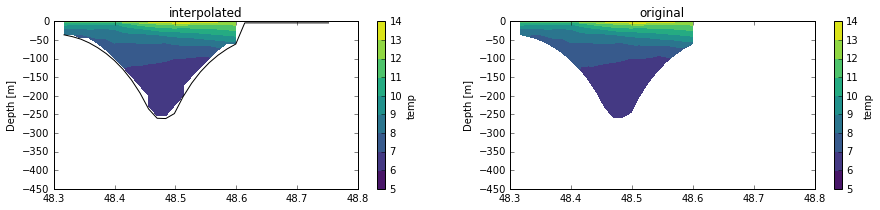

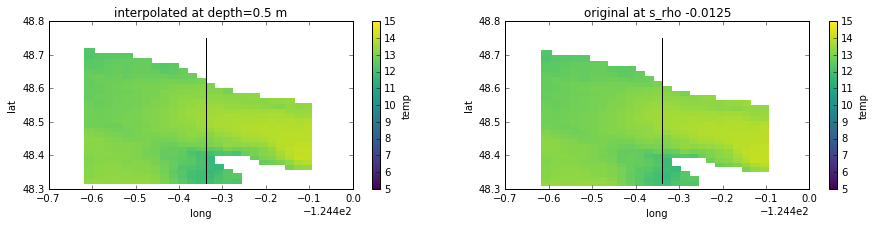

In [12]:
sl_dir = 'lat'
sl_val=13
t=3
s=39; k=0 #these are the values for looking at the surface. It is hard to comapre other depths.
clims=(5, 15)
levels=np.arange(5,15,1)
var_name='temp'
compare_depth_interp(weekly, depth_interps, depBC, var_name, levels, t, s, k, sl_val, sl_dir)

Salt

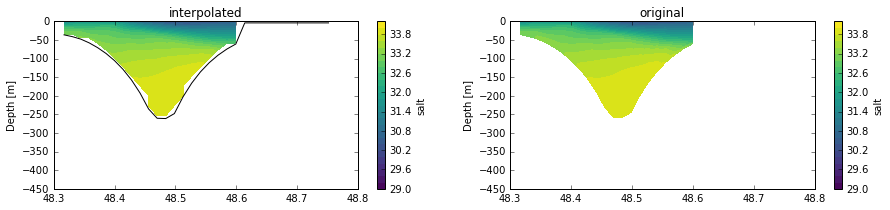

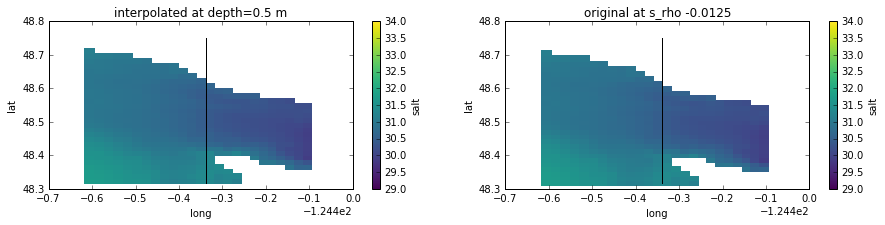

In [13]:
clims=(29, 34)
levels=np.arange(29,34.2,.2)
var_name='salt'
compare_depth_interp(weekly, depth_interps, depBC, var_name, levels, t, s, k, sl_val, sl_dir)

These comparisons look reasonable.

### b. Lateral

Next, interpolate laterally using griddata. Fill NaNs with nearest neighbour.

In [18]:
lateral_interps = interpolate_to_NEMO_lateral(depth_interps, weekly, lonBC, latBC, shape)

Comparisons with depth interpolated Live Ocean

In [19]:
def compare_lateral_interp(d_interps, dataset, l_interps, depths, lons, lats, shape, 
                           var_name, clims, t, k):
    """This function is not part of the algorithm for creating boundary conditions. 
    It is only a quick function written for comapring results. 
    It does not need to be carefully reviewed"""
    fig,axs = plt.subplots(1,2,figsize=(15,3))
    #Lateral interp
    ax=axs[0]
    longrid = lons.reshape(shape)
    latgrid = lats.reshape(shape)
    mesh=ax.pcolormesh(longrid, latgrid,
                       l_interps[var_name][t, k, :, :].reshape(shape),
                       vmin=clims[0], vmax=clims[1],cmap='viridis')
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label(var_name)
    ax.set_title('Laterally interpolated: {0:.3f} m'.format(depths[k]))
    #original lateral grid
    ax=axs[1]
    mesh=ax.pcolormesh(dataset.lon_rho.values[:], dataset.lat_rho.values[:],
                       d_interps[var_name][t, k, :, :],
                       vmin=clims[0], vmax=clims[1],cmap='viridis')
    cbar=plt.colorbar(mesh,ax=ax)
    cbar.set_label(var_name)
    ax.set_title('original lateral grid: {0:.3f} m'.format(depths[k]))
    ax.plot([longrid[0,0],longrid[-1,0]], [latgrid[0,0],latgrid[-1,0]], 'k-')
    ax.plot([longrid[0,0],longrid[0,-1]], [latgrid[0,0],latgrid[0,-1]], 'k-')
    ax.plot([longrid[-1,-1],longrid[-1,0]], [latgrid[-1,-1],latgrid[-1,0]], 'k-')
    ax.plot([longrid[0,-1],longrid[-1,-1]], [latgrid[0,-1],latgrid[-1,-1]], 'k-')
    #limits
    for ax in axs:
        ax.set_xlim([-125.1,-124.4])
        ax.set_ylim([48.3,48.8])

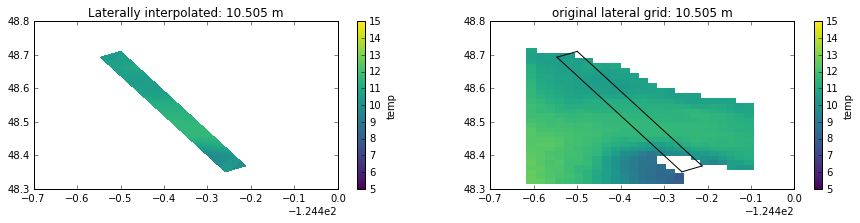

In [20]:
t=0
k=10
clims=(5, 15)
var_name='temp'
compare_lateral_interp(depth_interps, weekly, lateral_interps, depBC, lonBC, latBC, shape,
                       var_name, clims, t, k)

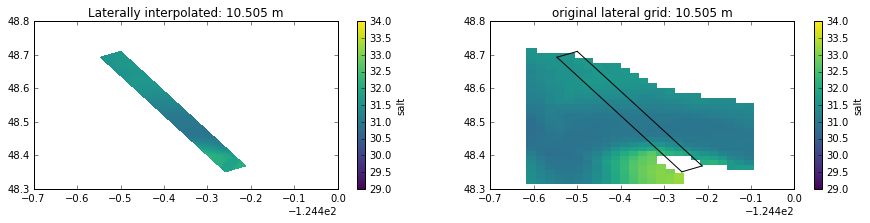

In [21]:
clims=(29, 34)
var_name='salt'
compare_lateral_interp(depth_interps, weekly, lateral_interps, depBC, lonBC, latBC, shape,
                       var_name, clims, t, k)

Again, this looks ok. We have also filled in land points with reasonable values. 

# Compare interpolated Live Ocean and  to current BCs

In [22]:
# Load current BCs
f = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/SalishSea2_Masson_corrected.nc')
salBC = f.variables['vosaline'][:]
tempBC = f.variables['votemper'][:]
time = f.variables['time_counter'][:]
#fake the dates
start = datetime.datetime(2016,1,1)
dates = [start + datetime.timedelta(weeks=int(d)) for d in time]
b = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy = b.variables['Bathymetry'][:]
nbjdta = f.variables['nbjdta'][:] 
nbidta = f.variables['nbidta'][:]

bathyBC = bathy[nbjdta, nbidta]
BC = {'salt': salBC, 'temp': tempBC}

In [23]:
#find time slices to compare
t1=0
t2=21
ts = {'LO': t1, 'NEMO': t2}
#check they are both first week of June
print(weekly.ocean_time.values[t1],dates[t2])

2016-06-01T00:00:00.000000000 2016-06-03 00:00:00


Full BC comparison. First week of June.

In [24]:
def compare_BCs_full(NEMO_BC, LO_interp, depths, tims, bathy, var_name, levels):
    fig,axs = plt.subplots(1,2,figsize=(15,5))
    #Live Ocean
    ax=axs[0]
    mesh=ax.contourf(np.arange(LO_interp[var_name].shape[-1]), depths,
                    LO_interp[var_name][tims['LO'], :, 0, :],
                    levels, cmap='viridis')
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label(var_name)
    ax.set_title('Live Ocean')
    #Our BCs
    ax=axs[1]
    mesh=ax.contourf(np.arange(NEMO_BC[var_name].shape[-1]), depths,
                    NEMO_BC[var_name][tims['NEMO'], :, 0,:], 
                    levels, cmap='viridis')
    cbar=plt.colorbar(mesh,ax=ax)
    cbar.set_label(var_name)
    ax.set_title('Our BCs')
    #limits and bathy
    for ax in axs:
        ax.set_ylabel('Depth [m]')
        ax.set_ylim(450,0)
        ax.set_xlabel('boundary index')
        ax.plot(np.arange(bathy.shape[1]), bathy[0,:], 'k-')

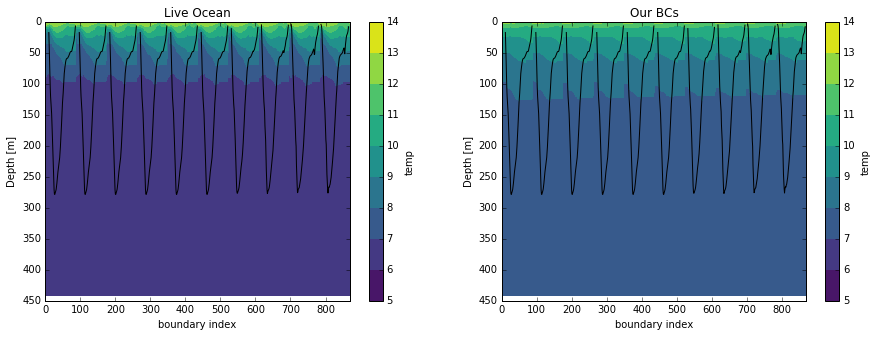

In [25]:
levels=np.arange(5,15,1)
var_name='temp'
compare_BCs_full(BC, lateral_interps, depBC, ts, bathyBC, var_name, levels)

* Black lines are NEMO bathymetry. 
* Live Ocean is cooler below 100m (6-7 deg C vs 7-8 deg C). And warmer in surface.
* A 'colder' current hugs the left boundary in our BCs (raised isotherms). Below 100m in Live Ocean the polarity of the isotherms on the left side reverses. Why?

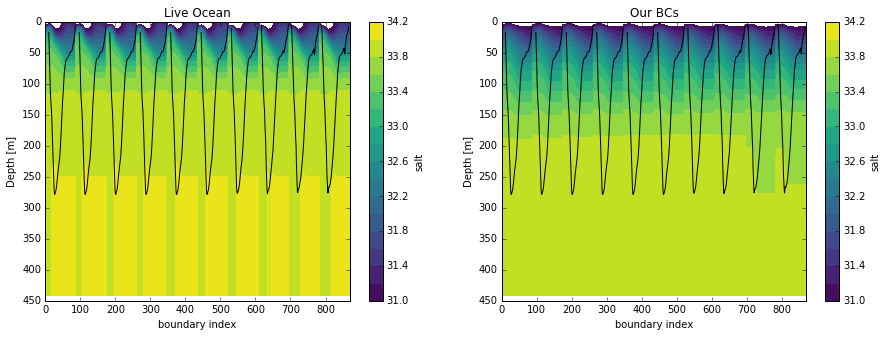

In [26]:
levels=np.arange(31,34.2,.2)
var_name='salt'
compare_BCs_full(BC, lateral_interps, depBC, ts, bathyBC, var_name, levels)

* Same polarity switch in the isohalines...

# Summary
* Given a list of Live Ocean files in chronological order, I  can interpolate onto our boundary with 4 function calls:
    * depBC, lonBC, latBC, shape =  load_SalishSea_boundary()
    * LO_dataset = load_LiveOcean(files, resample_interval='7D') - or choose a different sampling interval
    * depth_interps = interpolate_to_NEMO_depths(LO_dataset, depBC, ['salt', 'temp'])
    * lateral_interps = interpolate_to_NEMO_lateral(depth_interps, LO_dataset, lonBC, latBC, shape)

# Next steps
* For use in model runs, I need to figure out how to save as netCDF. Shouldn't be hard.

# Creating boundary forcing files

This set of functions generates boundary forcing files from Live Ocean results. One function does the trick, the others are helper functions

For example, 
~~~~
create_LiveOcean_TS_BCs('2016-06-01', '2016-07-31', '1D', 'monthly', 
                        basename = 'LO',
                        save_dir='/ocean/nsoontie/MEOPAR/LiveOcean/boundary_files/', 
                        LO_dir='/ocean/nsoontie/MEOPAR/LiveOcean/',
                        NEMO_BC='/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/SalishSea2_Masson_corrected.nc'
                        )
~~~~

creates forcing files for June 2016 and July 2016. The forcing files contained daily averaged fields. Two files are produced:
* LO_y2016m06.nc
* LO_y2016m07.nc

In [27]:
def create_LiveOcean_TS_BCs(start, end, avg_period, file_frequency, time_series = True,
                            basename = 'LO',
                            save_dir='/ocean/nsoontie/MEOPAR/LiveOcean/boundary_files/', 
                            LO_dir='/ocean/nsoontie/MEOPAR/LiveOcean/subdomain_files/',
                            NEMO_BC = '/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/SalishSea2_Masson_corrected.nc'
                            ):
    """Create a series of Live Ocean boundary condition files in date range [start, end]
    for use in the NEMO model.
    
    :arg str start: start date in format 'yyyy-mm-dd'

    :arg str end: end date in format 'yyyy-mm-dd
    
    :arg str avg_period: The averaging period for the forcing files.
    options are '1H' for hourly, '1D' for daily, '7D' for weekly, '1M' for monthly
    
    :arg str file_frequency: The frequency by which the files will be saved.
    Options are:
    * 'yearly' files that contain a year of data and look like *_yYYYY.nc
    * 'monthly' for files that contain a month of data and look like *_yYYYYmMM.nc
    * 'daily' for files that contain a day of data and look like *_yYYYYmMMdDD.nc
    where * is the basename.
    
    :arg time_series: Specifies that the boundary data is derived from a time series of LiveOcean
    nowcast results. If false, the files are from a single 72 hour run beginning on start, in which case,
    the argument end is ignored. 
    :type time_series: boolean
    
    :arg str basename: the base name of the saved files. 
    Eg. basename = 'LO', file_frequency = 'daily' saves files as 'LO_yYYYYmMMdDD.nc'
    
    :arg str save_dir: the directory in which to save the results.
    If a time series is not requested, resutls are saved in save_dir/subdir, where subdir is yyyy-mm-dd
    
    :arg str LO_dir: the directory in which Live Ocean results are stored.
    
    :arg str NEMO_BC: path to an example NEMO boundary condition file for loading boundary info. 
    """
    # Create metadeta for temperature and salinity
    var_meta = {'vosaline': {'grid': 'SalishSea2',
                             'long_name': 'Practical Salinity',
                             'units': 'psu'},
                'votemper': {'grid': 'SalishSea2',
                             'long_name': 'Potential Temperature',
                             'units': 'deg C'}
                } # We could pass a flag for conversion to TEOS-10, in which case metadata should be changed
    
    # Mapping from LiveOcean TS names to NEMO TS names
    LO_to_NEMO_var_map = {'salt': 'vosaline',
               'temp': 'votemper'}
    
    # Initialize var_arrays dict
    NEMO_var_arrays = {key : [] for key in LO_to_NEMO_var_map.values()}
    
    # Load BC information
    depBC, lonBC, latBC, shape =  load_SalishSea_boundary_grid(fname=NEMO_BC)
    
    # Load and interpolate Live Ocean
    if time_series:
        files = list_LO_time_series_files(start, end, LO_dir)
    else: 
        print('Preparing 72 hours of Live Ocean results. Argument end = {} is ignored'.format(end))
        files = list_LO_rundate_files(start, LO_dir)
        save_dir = os.path.join(save_dir, start)
        if not os.path.isdir(save_dir):
            os.mkdir(save_dir)
    LO_dataset = load_LiveOcean(files, resample_interval=avg_period)
    depth_interps = interpolate_to_NEMO_depths(LO_dataset, depBC, ['salt', 'temp'])
    lateral_interps = interpolate_to_NEMO_lateral(depth_interps, LO_dataset, lonBC, latBC, shape)
    lateral_interps['ocean_time'] = LO_dataset.ocean_time
    
    # divide up data and save into separate files
    separate_and_save_files(lateral_interps, avg_period, file_frequency, basename, save_dir,
                            LO_to_NEMO_var_map, var_meta, NEMO_var_arrays, NEMO_BC)


In [28]:
def list_LO_rundate_files(rundate, LO_dir):
    """ List 72 hours of Live Ocean files from a rundate.
    Example: if rundate='2016-06-01'  the listed files will be
    LO_dir/2016-05-31/ocean_his_0024_UBC.nc to LO_dir/2016-06-01/ocean_his_0072_UBC.nc
    The times in these files represent 2016-06-01 00:00:00 to 2016-06-03 23:00:00.
    
    :arg str rundate: rundate in format 'yyyy-mm-dd'
    
    :arg str LO_dir: the file path where Live Ocean results are stored
    
    :returns: list of Live Ocean file names
    """
    
    sdt = datetime.datetime.strptime(rundate,'%Y-%m-%d')
    files = glob.glob(os.path.join(LO_dir,sdt.strftime('%Y%m%d'), '*.nc'))
    sdt_m1 = sdt - datetime.timedelta(days=1)
    files.insert(0, os.path.join(LO_dir,sdt_m1.strftime('%Y%m%d'), 'ocean_his_0025_UBC.nc'))
    files.sort()
    del files[-1]
    
    return files

In [29]:
def separate_and_save_files(interpolated_data, avg_period,  file_frequency, basename, save_dir, 
                            LO_to_NEMO_var_map, var_meta, NEMO_var_arrays, NEMO_BC_file):
    """Separates and saves variables in interpolated_data into netCDF files given 
    a desired file frequency.
    
    :arg interpolated_data: a dictionary containing variable arrays and time. Keys are LO variable names.
    :type interpolated_data: dictionary of numpy arrays for varables and an xarray dataarray for time.
    
    :arg str avg_period: The averaging period for the forcing files.
    options are '1H' for hourly, '1D' for daily, '7D' for weekly, '1M' for monthly
    
    :arg str file_frequency: The frequency by which the files will be saved.
    Options are:
    * 'yearly' files that contain a year of data and look like *_yYYYY.nc
    * 'monthly' for files that contain a month of data and look like *_yYYYYmMM.nc
    * 'daily' for files that contain a day of data and look like *_yYYYYmMMdDD.nc
    where * is the basename.
    
    :arg str basename: the base name of the saved files. 
    Eg. basename = 'LO', file_frequency = 'daily' saves files as 'LO_yYYYYmMMdDD.nc'
    
    :arg str save_dir: the directory in which to save the results
    
    :arg LO_to_NEMO_var_map: a dictionary mapping between LO variable names (keys)
    NEMO variable names (values)
    :type LO_to_NEMO_var_map: a dictionary with string key-value pairs
    
    :arg var_meta: metadata for each variable in var_arrays. keys are NEMO variable names. 
    :type var_meta: a dictionary of dictionaries with key-value pairs of metadata
    
    :arg NEMO_var_arrays: a dictionary containing the boundary data to be saved.
    :type NEMO_var_arrays: dictionary of numpy arrays
    
    :arg str NEMO_BC_file: path to an example NEMO boundary condition file for loading boundary info. 
    
    """
    time_units = {'1H': 'hours', '1D': 'days', '7D': 'weeks', '1M': 'months'}
    index = 0
    first = datetime.datetime.strptime(
        str(interpolated_data['ocean_time'].values[0])[0:-3], '%Y-%m-%dT%H:%M:%S.%f'
    )
    # I don't really like method of retrieving the date from LO results. Is it necessary? .
    first = first.replace(second=0, microsecond=0)
    for counter, t in enumerate(interpolated_data['ocean_time']):
        date = datetime.datetime.strptime(str(t.values)[0:-3], '%Y-%m-%dT%H:%M:%S.%f')
        conditions ={'yearly':  date.year  != first.year, 
                     'monthly': date.month != first.month,  # doesn't work if same months, different year...
                     'daily':   date.date() != first.date()
                     }
        filenames = {'yearly': os.path.join(save_dir,'{}_y{}.nc'.format(basename, first.year)),
                     'monthly': os.path.join(save_dir,'{}_y{}m{:02d}.nc'.format(basename, first.year,
                                                                                first.month)),
                     'daily': os.path.join(save_dir,'{}_y{}m{:02d}d{:02d}.nc'.format(basename, first.year,
                                                                                     first.month, first.day))
                    }
        if conditions[file_frequency]:
                for LO_name, NEMO_name in LO_to_NEMO_var_map.items():
                    NEMO_var_arrays[NEMO_name] = interpolated_data[LO_name][index:counter,: , :, :]
                create_sub_file(first, time_units[avg_period], 
                                NEMO_var_arrays, var_meta, NEMO_BC_file, filenames[file_frequency])
                first = date
                index = counter
        elif counter == interpolated_data['ocean_time'].values.shape[0]-1:
                for LO_name, NEMO_name in LO_to_NEMO_var_map.items():
                    NEMO_var_arrays[NEMO_name] = interpolated_data[LO_name][index:, :, :, :]
                create_sub_file(first, time_units[avg_period],
                                NEMO_var_arrays, var_meta, NEMO_BC_file, filenames[file_frequency])


In [30]:
def create_sub_file(date, time_unit, var_arrays, var_meta,  NEMO_BC, filename):
    """Save a netCDF file for boundary data stored in var_arrays.
    
    :arg date: Date from which time in var_arrays is measured.
    :type date: datetime object
    
    :arg str time_unit: Units that time in var_arrays is measured in. e.g 'days' or 'weeks' or 'hours'
    
    :arg var_arrays: a dictionary containing the boundary data to be saved.
    :type var_arrays: dictionary of numpy arrays
    
    :arg var_meta: metadata for each variable in var_arrays
    :type var_meta: a dictionary of dictionaries with key-value pairs of metadata
    
    :arg str NEMO_BC: path to a current NEMO boundary file. Used for looping up boundary indices etc.
    
    :arg str filename: The name of the file to be saved.
    """    
    # Set up xarray Dataset
    ds = xr.Dataset()
    
    # Load BC information
    f = nc.Dataset(NEMO_BC)
    depBC = f.variables['deptht']
    
    # Copy variables and attributes of non-time dependent variables from a previous BC file
    keys = list(f.variables.keys())
    for var_name in var_arrays:
        if var_name in keys: # check that var_name can be removed 
            keys.remove(var_name)
    keys.remove('time_counter') # Allow xarray to build the arrays for these coordinates
    keys.remove('deptht')
    # Now iterate through remaining variables in old BC file and add to dataset
    for key in keys:
        var = f.variables[key]
        temp_array = xr.DataArray(var,
                                  name = key,
                                  dims = list(var.dimensions),
                                  attrs = {att: var.getncattr(att) for att in var.ncattrs()}
                                 )
        ds = xr.merge([ds, temp_array])
    # Add better units information nbidta etc
    for varname in ['nbidta', 'nbjdta', 'nbrdta']:
        ds[varname].attrs['units'] = 'index'
    # Now add the time-dependent model variables
    for var_name, var_array in var_arrays.items():
        data_array = xr.DataArray(var_array,
                                  name = var_name,
                                  dims = ['time_counter', 'deptht', 'yb', 'xbT'],
                                  coords = {'deptht': (['deptht'], depBC[:]),
                                            'time_counter': np.arange(var_array.shape[0])
                                            }  ,
                                  attrs = var_meta[var_name]
                                 )
        ds = xr.merge([ds, data_array])
    # Fix metadata on time_counter
    ds['time_counter'].attrs['units'] = '{} since {}'.format(time_unit, date.strftime('%Y-%m-%d %H:%M:%S'))
    ds['time_counter'].attrs['time_origin'] = date.strftime('%Y-%m-%d %H:%M:%S')
    ds['time_counter'].attrs['long_name'] = 'Time axis'
    # Add metadata for deptht
    ds['deptht'].attrs = {att: depBC.getncattr(att) for att in depBC.ncattrs()}
    # Add some global attributes
    ds.attrs = {'acknowledgements': 'Live Ocean http://faculty.washington.edu/pmacc/LO/LiveOcean.html',
                'creator_email': 'nsoontie@eos.ubc.ca',
                'creator_name': 'Salish Sea MEOPAR Project Contributors',
                'creator_url': 'https://salishsea-meopar-docs.readthedocs.org/',
                'institution': 'UBC EOAS',
                'institution_fullname': 'Earth, Ocean & Atmospheric Sciences, University of British Columbia',
                'summary': 'Temperature and Salinity from the Live Ocean model interpolated in space '\
                            'onto the Salish Sea NEMO Model western open boundary. ',
                'source': 'http://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/analysis-nancy/raw/tip/notebooks/'\
                          'LiveOcean/Interpolating%20Live%20Ocean%20to%20our%20boundary.ipynb',
                'history': '[{}] File creation.'.format(datetime.datetime.today().strftime('%Y-%m-%d'))}
    ds.to_netcdf(filename)
    print('Saved {}'.format(filename))

## Testing time series creation

In [31]:
create_LiveOcean_TS_BCs('2016-06-01', '2016-07-31', '1D', 'monthly', 
                        save_dir='/ocean/nsoontie/MEOPAR/LiveOcean/boundary_files/monthly_1D_avg/',
                        time_series=True)

Saved /ocean/nsoontie/MEOPAR/LiveOcean/boundary_files/monthly_1D_avg/LO_y2016m06.nc
Saved /ocean/nsoontie/MEOPAR/LiveOcean/boundary_files/monthly_1D_avg/LO_y2016m07.nc


## Testing single run date creation 

In [32]:
create_LiveOcean_TS_BCs('2016-06-09', '2016-06-09', '1H', 'daily', time_series=False,
                       save_dir='/ocean/nsoontie/MEOPAR/LiveOcean/boundary_files/test/',
                       LO_dir = '/ocean/nsoontie/MEOPAR/LiveOcean/subdomain_files/')

Preparing 72 hours of Live Ocean results. Argument end = 2016-06-09 is ignored
Saved /ocean/nsoontie/MEOPAR/LiveOcean/boundary_files/test/2016-06-09/LO_y2016m06d09.nc
Saved /ocean/nsoontie/MEOPAR/LiveOcean/boundary_files/test/2016-06-09/LO_y2016m06d10.nc
Saved /ocean/nsoontie/MEOPAR/LiveOcean/boundary_files/test/2016-06-09/LO_y2016m06d11.nc


## Notes
* Live Ocean files store salinity and temperature as Practical Salinity and Potential Temperature. I could add a convert_teos=true flag to create_LiveOcean_TS_boundary
* I need to run 
~~~~ 
ncks --mk_rec_dmn=time_counter infile outfile 
~~~~ 
for these files to work in NEMO. Right now I can only run that on salish from the command line.
* This depends on some python functions that Parker sent me for creating the depths and grid. Parker's funtions work with netCDF4 objects.
    1. Where do we store Parker's code? ... private_tools or permission on a public repo? 
    2. Should we rework Parker's code to use xarray?
* create_sub_file should be able to accommodate variables besides T+S. My suggestion is to create a new function similar to create_LiveOcean_TS_BCs. There is some repeated code that could be cleaned up.
* I don't really like that some metadata and information is read from the old boundary files. Is that a bad choice?
* I don't like that deptht is both a coordinate and a variable but this choice is most consistent with current BC files


# LiveOcean_BCs.py
The following functions have been moved into LiveOcean_BCs.py
* methods for interpolation
~~~~
load_SalishSea_boundary_grid()
load_LiveOcean()
interpolate_to_NEMO_depths()
interpolate_to_NEMO_lateral()
fill_NaNs_with_nearest_neighbour()
~~~~

* methods for file creation
~~~~
create_LiveOcean_TS_BCs()
create_sub_file()
list_LO_time_series_files()
list_LO_rundate_files()
separate_and_save_files()
~~~~